In [5]:
import numpy as np
import sys 
sys.path.append(r'../Python Script/')

from sympy import symbols, simplify, derive_by_array
from scipy.integrate import solve_ivp
from xLSINDy import *
from sympy.physics.mechanics import *
from sympy import *
import sympy
import torch
import sys 
import math
sys.path.append(r'../../../HLsearch/')
import HLsearch as HL
import matplotlib.pyplot as plt

In [6]:
# functions to generate pendulum data

def generate_data(func, time, init_values, omega):
    sol = solve_ivp(func,[time[0],time[-1]],init_values,t_eval=time,method='RK45',args=[omega],rtol=1e-10,atol=1e-10)
    return sol.y.T, np.array([func(time[i],sol.y.T[i,:],omega) for i in range(sol.y.T.shape[0])],dtype=np.float64)
    # first output is X array in [x,x_dot] format
    # second output is X_dot array in [x_dot,x_doubledot] format

def pendulum(t,x,omega):
    return x[1],-9.81*np.sin(x[0]) + math.sin(omega*t) # the 'math.sin(omega*t)' is a sinusoidal external torque

In [7]:
#Saving Directory
rootdir = "../Single Pendulum/Data/"

num_sample = 100
create_data = True
training = True
save = False
noiselevel = 2e-2

In [8]:
if(create_data):
    X, Xdot, Tau = [], [], []
    for i in range(num_sample):
        t = np.arange(0,5,0.01)

        # initial conditions
        theta = np.random.uniform(-np.pi, np.pi)
        thetadot = np.random.uniform(-2.1,2.1)
        cond = 0.5*thetadot**2 - np.cos(theta)
        #checking condition so that it does not go full loop => *do we need this?
        while(cond>0.99):
            theta = np.random.uniform(-np.pi, np.pi)
            thetadot = np.random.uniform(-2.1,2.1)
            cond = 0.5*thetadot**2 - np.cos(theta)
        
        # define the external actuation
        def external_torque(t, omega): return np.sin(omega*t)
        act_freq = np.random.uniform(1.0, 4.0) # generate random frequency
        tau = external_torque(t,act_freq)
        
        y_0 = np.array([theta, thetadot])
        x,xdot = generate_data(pendulum, t, y_0, act_freq)
        X.append(x)
        Xdot.append(xdot)
        Tau.append(tau)
    if(save==True):
        np.save(rootdir + "Active/X.npy", X)
        np.save(rootdir + "Active/Xdot.npy", Xdot)
        np.save(rootdir + "Active/Tau.npy", Tau)
else:
    X = np.load(rootdir + "Active/X.npy")
    Xdot = np.load(rootdir + "Active/Xdot.npy")
    Tau = np.load(rootdir + "Active/Tau.npy")

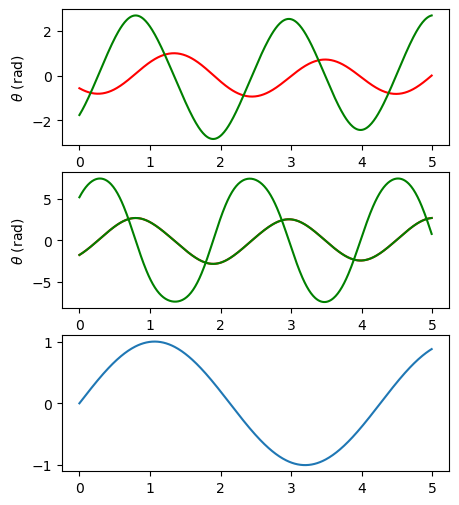

In [9]:
fig, ax = plt.subplots(3,1,figsize=(5,6))

ax[0].plot(t, X[0][:,0], 'r')
ax[0].plot(t, X[0][:,1], 'g')
ax[0].set_ylabel('$\\theta$ (rad)')

ax[1].plot(t, Xdot[0][:,0], 'r')
ax[1].plot(t, X[0][:,1], 'g')
ax[1].plot(t, Xdot[0][:,1], 'g')
ax[1].set_ylabel('$\\theta$ (rad)')

ax[2].plot(t, Tau[0])

In [10]:
#adding noise
X = np.vstack(X)
Xdot = np.vstack(Xdot)
Tau = np.vstack(Tau)

mu, sigma = 0, noiselevel
noise = np.random.normal(mu, sigma, X.shape[0])
for i in range(X.shape[1]):
    X[:,i] = X[:,i]+noise
    Xdot[:,i] = Xdot[:,i]+noise

In [11]:
states_dim = 2
states = ()
states_dot = ()
for i in range(states_dim):
    if(i<states_dim//2):
        states = states + (symbols('x{}'.format(i)),)
        states_dot = states_dot + (symbols('x{}_t'.format(i)),)
    else:
        states = states + (symbols('x{}_t'.format(i-states_dim//2)),)
        states_dot = states_dot + (symbols('x{}_tt'.format(i-states_dim//2)),)
print('states are:',states)
print('states derivatives are: ', states_dot)

states are: (x0, x0_t)
states derivatives are:  (x0_t, x0_tt)


In [12]:
#Turn from sympy to str
states_sym = states
states_dot_sym = states_dot
states = list(str(descr) for descr in states)
states_dot = list(str(descr) for descr in states_dot)

In [13]:
#build function expression for the library in str
expr= HL.buildFunctionExpressions(2,states_dim,states,use_sine=True)
print(expr)
expr.pop(5)


['x0', 'x0_t', 'sin(x0)', 'cos(x0)', 'x0**2', 'x0*x0_t', 'x0_t**2', 'x0*sin(x0)', 'x0_t*sin(x0)', 'sin(x0)**2', 'x0*cos(x0)', 'x0_t*cos(x0)', 'sin(x0)*cos(x0)', 'cos(x0)**2']


'x0*x0_t'

In [14]:
device = 'cuda:0'

In [15]:
Zeta, Eta, Delta = LagrangianLibraryTensor(X,Xdot,expr,states,states_dot,scaling=True)
Eta = Eta.to(device)
Zeta = Zeta.to(device)
Delta = Delta.to(device)

In [11]:
mask = torch.ones(len(expr),device=device)
xi_L = torch.ones(len(expr), device=device).data.uniform_(-10,10)
prevxi_L = xi_L.clone().detach()

In [12]:
def loss(pred, targ, coef):
    loss = torch.mean((pred - targ)**2) 
    return loss 

In [13]:
def clip(w, alpha):
    clipped = torch.minimum(w,alpha)
    clipped = torch.maximum(clipped,-alpha)
    return clipped

def proxL1norm(w_hat, alpha):
    if(torch.is_tensor(alpha)==False):
        alpha = torch.tensor(alpha)
    w = w_hat - clip(w_hat,alpha)
    return w


In [14]:
def training_loop(coef, prevcoef, Zeta, Eta, Delta,xdot, bs, lr, lam):
    loss_list = []
    tl = xdot.shape[0]
    n = xdot.shape[1]

    if(torch.is_tensor(xdot)==False):
        xdot = torch.from_numpy(xdot).to(device).float()
    
    for i in range(tl//bs):
        
        #v = coef.clone().detach().requires_grad_(True)
        
        #computing acceleration with momentum
        v = (coef + ((i-1)/(i+2))*(coef - prevcoef)).clone().detach().requires_grad_(True)
        
        prevcoef = coef.clone().detach()


        #Computing loss
        zeta = Zeta[:,:,:,i*bs:(i+1)*bs]
        eta = Eta[:,:,:,i*bs:(i+1)*bs]
        delta = Delta[:,:,i*bs:(i+1)*bs]
        x_t = xdot[i*bs:(i+1)*bs,:]

        #forward
        q_tt_pred = lagrangianforward(v,mask,zeta,eta,delta,x_t,device)
        q_tt_true = xdot[i*bs:(i+1)*bs,n//2:].T
        

        #tau_pred = tauforward(coef,mask,zeta,eta,delta,x_t)
        #tau_true = torch.zeros(tau_pred.shape,device=device)
        #tau_true[0,:] = 1
        
        lossval = loss(q_tt_pred, q_tt_true, coef)
        
        #Backpropagation
               
        lossval.backward()
        with torch.no_grad():
            vhat = v - lr*v.grad
            coef = (proxL1norm(vhat,lr*lam)).clone().detach()

        
    
        
        loss_list.append(lossval.item())
    print("Average loss : " , torch.tensor(loss_list).mean().item())
    return coef, prevcoef, torch.tensor(loss_list).mean().item()

In [15]:
Epoch = 100
i = 1
lr = 1e-4
lam = 0.1
temp = 1000
while(i<=Epoch):
    print("\n")
    print("Stage 1")
    print("Epoch "+str(i) + "/" + str(Epoch))
    print("Learning rate : ", lr)
    xi_L , prevxi_L, lossitem= training_loop(xi_L,prevxi_L,Zeta,Eta,Delta,Xdot,128,lr=lr,lam=lam)
    if(temp <=5e-3):
        break
    if(temp <=1e-1):
        lr = 1e-5
    temp = lossitem
    i+=1



Stage 1
Epoch 1/100
Learning rate :  0.0001
Average loss :  39.20124816894531


Stage 1
Epoch 2/100
Learning rate :  0.0001
Average loss :  38.194419860839844


Stage 1
Epoch 3/100
Learning rate :  0.0001
Average loss :  37.73448181152344


Stage 1
Epoch 4/100
Learning rate :  0.0001
Average loss :  37.42933654785156


Stage 1
Epoch 5/100
Learning rate :  0.0001
Average loss :  37.19251251220703


Stage 1
Epoch 6/100
Learning rate :  0.0001
Average loss :  36.99118423461914


Stage 1
Epoch 7/100
Learning rate :  0.0001
Average loss :  36.80839920043945


Stage 1
Epoch 8/100
Learning rate :  0.0001
Average loss :  36.63421630859375


Stage 1
Epoch 9/100
Learning rate :  0.0001
Average loss :  36.46073532104492


Stage 1
Epoch 10/100
Learning rate :  0.0001
Average loss :  36.28203201293945


Stage 1
Epoch 11/100
Learning rate :  0.0001
Average loss :  36.09148025512695


Stage 1
Epoch 12/100
Learning rate :  0.0001
Average loss :  35.88092803955078


Stage 1
Epoch 13/100
Learning rate

In [16]:
## Thresholding small indices ##
threshold = 1e-2
surv_index = ((torch.abs(xi_L) >= threshold)).nonzero(as_tuple=True)[0].detach().cpu().numpy()
expr = np.array(expr)[surv_index].tolist()

xi_L =xi_L[surv_index].clone().detach().requires_grad_(True)
prevxi_L = xi_L.clone().detach()
mask = torch.ones(len(expr),device=device)

## obtaining analytical model
xi_Lcpu = np.around(xi_L.detach().cpu().numpy(),decimals=2)
L = HL.generateExpression(xi_Lcpu,expr,threshold=1e-2)
print(simplify(L))

0.29*x0_t**2 + 2.92*x0_t + 11.41*cos(x0)


In [17]:
## Next round Selection ##
for stage in range(2):
    
    #Redefine computation after thresholding
    Zeta, Eta, Delta = LagrangianLibraryTensor(X,Xdot,expr,states,states_dot,scaling=False)
    Eta = Eta.to(device)
    Zeta = Zeta.to(device)
    Delta = Delta.to(device)

    #Training
    Epoch = 100
    i = 1
    lr = 3e-5
    if(stage==1):
        lam = 0
    else:
        lam = 0.01
    temp = 1000
    while(i<=Epoch):
        print("\n")
        print("Stage " + str(stage+2))
        print("Epoch "+str(i) + "/" + str(Epoch))
        print("Learning rate : ", lr)
        xi_L , prevxi_L, lossitem= training_loop(xi_L,prevxi_L,Zeta,Eta,Delta,Xdot,128,lr=lr,lam=lam)
        temp = lossitem
        if(temp <=1e-6):
            break
        i+=1
    
    ## Thresholding small indices ##
    threshold = 1e-1
    surv_index = ((torch.abs(xi_L) >= threshold)).nonzero(as_tuple=True)[0].detach().cpu().numpy()
    expr = np.array(expr)[surv_index].tolist()

    xi_L =xi_L[surv_index].clone().detach().requires_grad_(True)
    prevxi_L = xi_L.clone().detach()
    mask = torch.ones(len(expr),device=device)

    ## obtaining analytical model
    xi_Lcpu = np.around(xi_L.detach().cpu().numpy(),decimals=3)
    L = HL.generateExpression(xi_Lcpu,expr,threshold=1e-2)
    print("Result stage " + str(stage+2) + ":" , simplify(L))



Epoch 1/100
Learning rate :  3e-05
Average loss :  0.5810737013816833


Epoch 2/100
Learning rate :  3e-05
Average loss :  0.02612227573990822


Epoch 3/100
Learning rate :  3e-05
Average loss :  0.026127925142645836


Epoch 4/100
Learning rate :  3e-05
Average loss :  0.026125963777303696


Epoch 5/100
Learning rate :  3e-05
Average loss :  0.02612675353884697


Epoch 6/100
Learning rate :  3e-05
Average loss :  0.026130858808755875


Epoch 7/100
Learning rate :  3e-05
Average loss :  0.02612759917974472


Epoch 8/100
Learning rate :  3e-05
Average loss :  0.026126032695174217


Epoch 9/100
Learning rate :  3e-05
Average loss :  0.026126069948077202


Epoch 10/100
Learning rate :  3e-05
Average loss :  0.02611963078379631


Epoch 11/100
Learning rate :  3e-05
Average loss :  0.026125838980078697


Epoch 12/100
Learning rate :  3e-05
Average loss :  0.0261271670460701


Epoch 13/100
Learning rate :  3e-05
Average loss :  0.02612527459859848


Epoch 14/100
Learning rate :  3e-05
Avera

In [18]:
if(save==True):
    #Saving Equation in string
    text_file = open(rootdir + "lagrangian_" + str(noiselevel)+ "_noise.txt", "w")
    text_file.write(L)
    text_file.close()